In [1]:
%matplotlib inline
import numpy as np
import cv2
import pandas as pd
import glob
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from lesson_functions import *

In [2]:
vehicles=glob.glob('data/vehicles/*/*')
non_vehicles=glob.glob('data/non-vehicles//*/*')

In [3]:
random.shuffle(vehicles)
random.shuffle(non_vehicles)

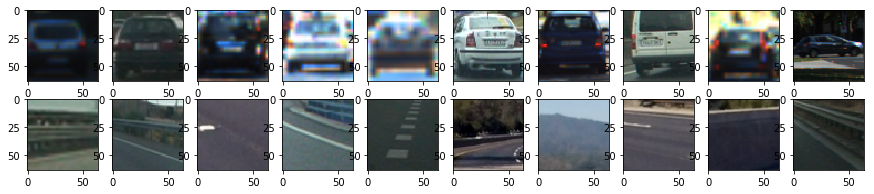

In [4]:
fig, ax = plt.subplots(2,10)
fig.set_figwidth(15)
fig.set_figheight(3)

for i in range(10):
    ax[0][i].imshow(mpl.image.imread(vehicles[i]))
    ax[1][i].imshow(mpl.image.imread(non_vehicles[i]))
    

In [5]:
names=vehicles+non_vehicles
y=np.array([1 for i in range(len(vehicles))]+[0 for i in range(len(non_vehicles))])

In [7]:
from skimage.feature import hog
from tqdm import tqdm_notebook

color_space =  'RGB'#, 'HSV', 'LUV', 'HLS', 'YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


all_features=[np.array(extract_features(names, color_space=sp, 
                       spatial_size=spatial_size, hist_bins=hist_bins, 
                       orient=orient, pix_per_cell=pix_per_cell, 
                       cell_per_block=cell_per_block, 
                       hog_channel=hog_channel, spatial_feat=spatial_feat, 
                       hist_feat=hist_feat, hog_feat=hog_feat, preprocessing=False)) for sp in \
              tqdm_notebook(['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'])]

/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [8]:
from sklearn.cross_validation import KFold
cv=KFold(len(names),n_folds=3,shuffle=True,random_state=0)

/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def hist_features(img, nbins=32, bins_range=(0,256)):
    colors=(cv2.COLOR_RGB2HSV, cv2.COLOR_RGB2LUV,cv2.COLOR_RGB2HLS,cv2.COLOR_RGB2YUV,\
           cv2.COLOR_RGB2HLS,cv2.COLOR_RGB2YUV,cv2.COLOR_RGB2YCrCb)
    
    return np.concatenate([color_hist(img, nbins=nbins, bins_range=bins_range)]+\
                          [color_hist(cv2.cvtColor(img, color), nbins=nbins, bins_range=bins_range) \
                        for color in colors])

def get_hist_features(imgs, nbins=32, bins_range=(0,256), from_file=True):
    f=mpl.image.imread if from_file else lambda x:x
    return np.concatenate([[hist_features(f(a), bins_range=bins_range, nbins=nbins)] \
                               for a in imgs],axis=0)
    
        

In [13]:
#hist_features=get_hist_features(names)

In [14]:
#X=np.concatenate([hog_features,hist_features],axis=1)

In [15]:
from sklearn.model_selection import train_test_split

#X_train, X_test, 
y_train, y_test, names_train, names_test = \
    train_test_split(y, names, test_size=0.3, random_state=0)

In [11]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC

params={'color_space':'HLS', \
                        'spatial_size':spatial_size, 'hist_bins':hist_bins, \
                        'orient':orient, 'pix_per_cell':pix_per_cell, \
                        'cell_per_block':cell_per_block, \
                        'hog_channel':hog_channel, 'spatial_feat':spatial_feat, \
                        'hist_feat':hist_feat, 'hog_feat':hog_feat, 'preprocessing':False}

#('hog',FunctionTransformer(func=extract_features)),\
pl=Pipeline([ \
             ('scalar',StandardScaler()), \
             ('svm',LinearSVC())])

In [18]:
from sklearn.metrics import accuracy_score, f1_score

color_spaces=['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

preds=np.zeros((len(color_spaces),len(y)),dtype=np.uint8)

for i in range(len(color_spaces)):
    res=[]
    for a,b in cv:
        pl.fit(all_features[i][a], y[a])
        pred=pl.predict(all_features[i][b])
        res.append([accuracy_score(y[b],pred), f1_score(y[b],pred)])
        preds[i][b]=pred
        
    print (color_spaces[i],np.mean(res,axis=0))


RGB [ 0.96599099  0.96558496]
HSV [ 0.95377252  0.95323295]
LUV [ 0.97899775  0.97869541]
HLS [ 0.95135135  0.95066047]
YUV [ 0.97387387  0.97350579]
YCrCb [ 0.97415541  0.97374161]


In [42]:
pl.fit(all_features[0],y)

Pipeline(steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [25]:
pred=pl.predict(names_test)

/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [26]:
from sklearn.metrics import accuracy_score, f1_score

accuracy_score(y_test,pred)

#y_test.sum(),pred.sum()

0.97109609609609615

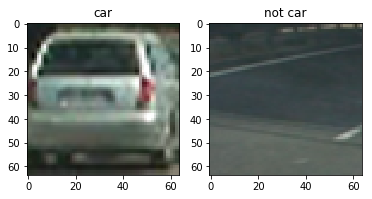

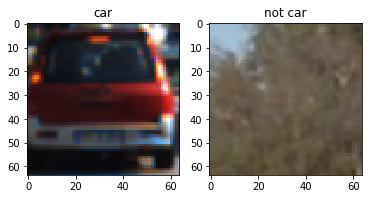

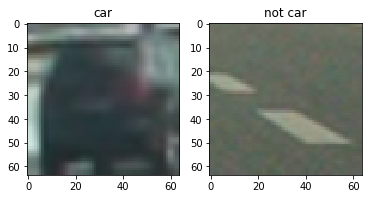

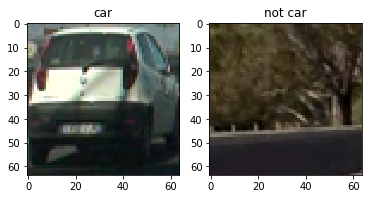

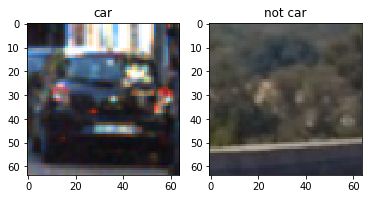

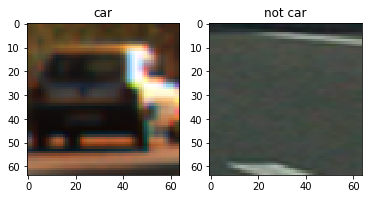

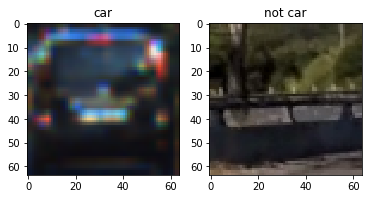

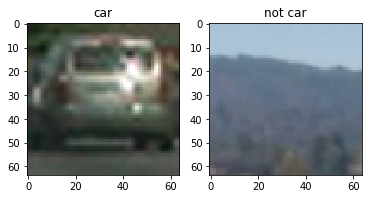

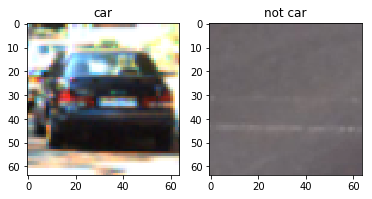

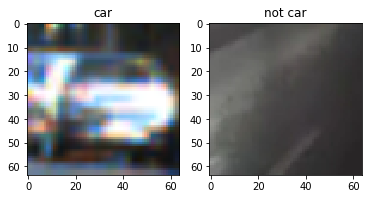

In [14]:
for i,j in zip(np.where(y_test==1)[0][:10],np.where(y_test==0)[0][:10]):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(mpl.image.imread(names_test[i]))
    ax[0].set_title('car' if pred[i]==1 else 'not car')
    if pred[i]!=y_test[i]:
        ax[0].plot(range(64),range(64),color='red')
        ax[0].plot([64-a for a in range(64)],range(64),color='red')
    
    ax[1].imshow(mpl.image.imread(names_test[j]))
    ax[1].set_title('car' if pred[j]==1 else 'not car')
    
    
    if pred[j]!=y_test[j]:
        ax[1].plot(range(64),range(64),color='red')
        ax[1].plot([64-a for a in range(64)],range(64),color='red')
    
    plt.show()

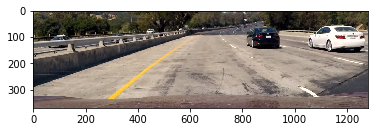

In [19]:
gl=glob.glob('test_images/*')
for a in gl[:1]:
    img=mpl.image.imread(a)
    plt.imshow(img[350:])
    plt.show()

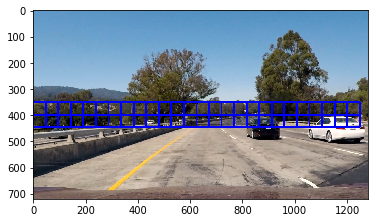

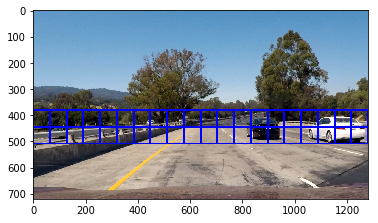

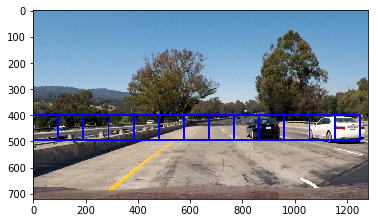

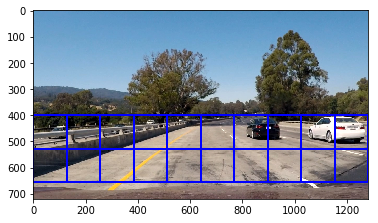

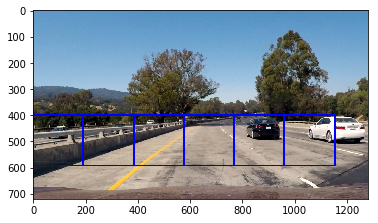

In [20]:
box_sizes=[(48,350,450),
           (64,380,380+128),\
           (64+32,400,500),\
           (128,400,700),\
           (128+64,400,700)
          ]

for size, y_start, y_stop in box_sizes:
    plt.imshow(draw_boxes(img,slide_window(img,xy_overlap=(0,0),\
                                           xy_window=(size,size),\
                                           y_start_stop=(y_start,y_stop))))
    plt.show()

In [21]:
bboxes=[]
#64,64+32,128,
#for size in (64,64+32,128,128+64,256,256+126,512):
#    bboxes.extend(slide_window(img[350:],xy_overlap=(0.75,0.75),xy_window=(size,size)))
 
for size, y_start, y_stop in box_sizes:
    bboxes.extend(slide_window(img,xy_overlap=(0.75,0.75),\
                                           xy_window=(size,size),\
                                           y_start_stop=(y_start,y_stop)))
    
#bboxes=np.array(bboxes)+np.array([0,350])

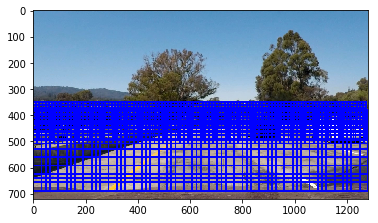

In [22]:
plt.imshow(draw_boxes(img,bboxes))

In [23]:
def get_sample(img, bboxes, f):
    samples=[]
    good_boxes=[]
    for box in bboxes:
        sample=img[box[0][1]:box[1][1],box[0][0]:box[1][0]]
        samples.append(f(cv2.resize(sample,(64,64))))
        good_boxes.append(box)

        #except:
        #    bad.append()

    return np.array(samples)


In [43]:
def get_sample_feature(sample):
    return \
 extract_features([sample], color_space='RGB', 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, from_file=False,preprocessing=False)[0]
    
#sample_histfeatures=get_hist_features(samples,from_file=False)

In [96]:
#sample_histfeatures=get_hist_features(samples,from_file=False)

In [26]:
pred=pl.predict(sample_features)

NameError: name 'sample_features' is not defined

array([0, 0, 0, ..., 0, 0, 0])

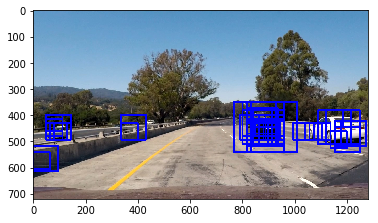

In [27]:
plt.imshow(draw_boxes(img,[(tuple(good_boxes[i][0]),tuple(good_boxes[i][1])) \
                           for i in range(len(good_boxes)) if pred[i]]))

In [28]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = [(tuple(good_boxes[i][0]),tuple(good_boxes[i][1])) \
#                           for i in range(len(good_boxes)) if pred[i]]

# Read in image similar to one shown above 
image = img

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_heat (image, box_list, threshhold=1):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)


    # Add heat to each box in box list
    heat = add_heat(heat,box_list)


    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshhold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure(figsize=(15,5))

    #fig.set_figwidth(15)
    #fig.set_figheight(3)

    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()

/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


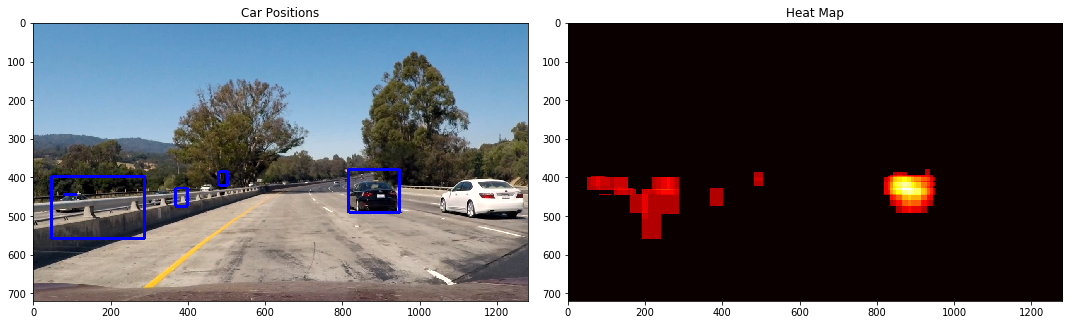

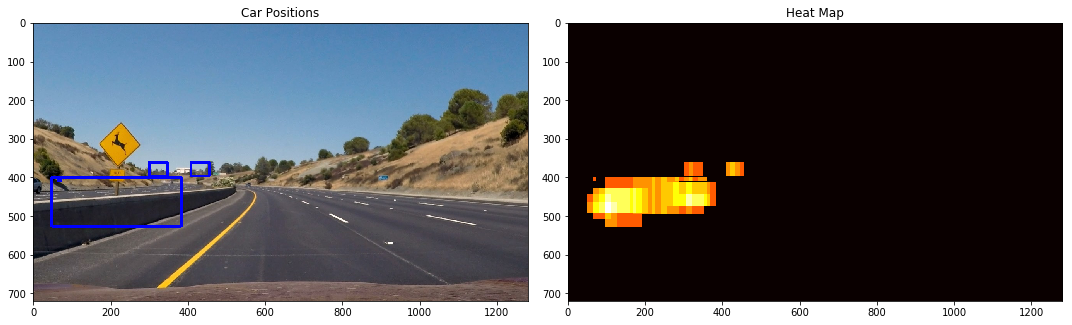

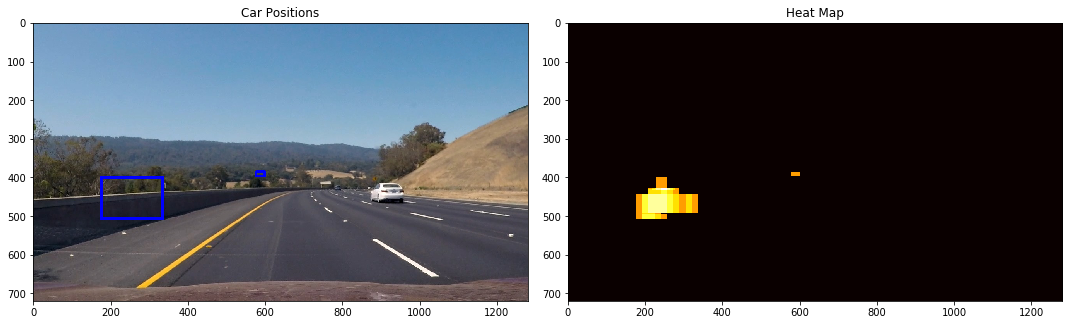

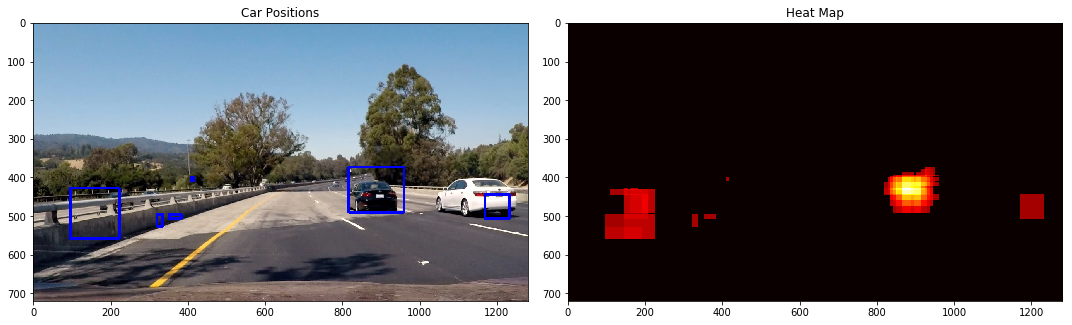

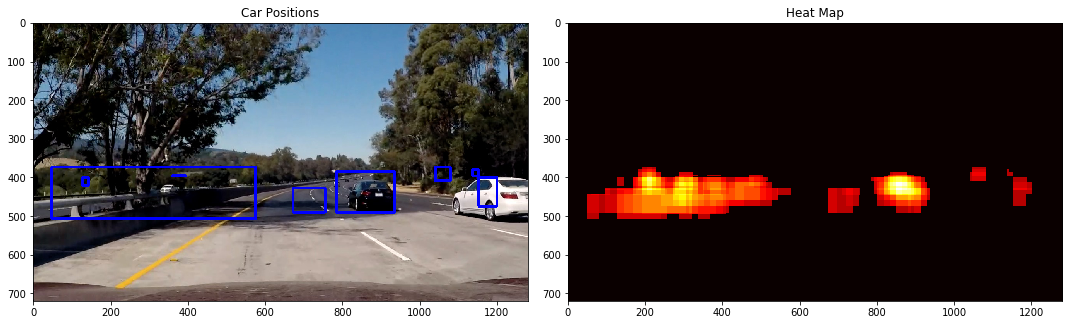

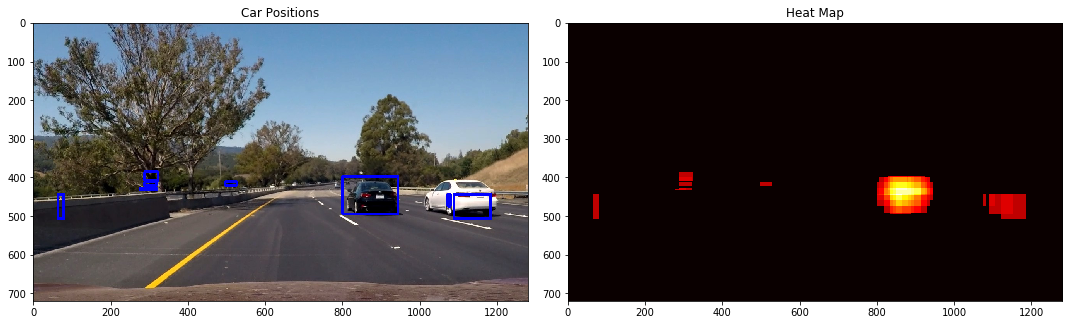

In [45]:
gl=glob.glob('test_images/*')
for a in gl:
    img=mpl.image.imread(a)
    samples=get_sample(img, bboxes, get_sample_feature)
    pred=pl.predict(samples)
    
    draw_heat(img,[a for i,a in enumerate(bboxes) if pred[i]],threshhold=5)

In [105]:
from sklearn.neighbors import NearestNeighbors

pl2=Pipeline([('sc',StandardScaler()),('nn',NearestNeighbors())])

In [110]:
sc=StandardScaler()
X_s=sc.fit_transform(X)

In [112]:
nn=NearestNeighbors(n_jobs=-1)
nn.fit(X_s)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [90]:
gl_far=glob.glob('data/vehicles/GTI_Far/*')

In [91]:
ch=get_hist_features(gl_far)

In [99]:
dist=((ch[:-1]-ch[1:])**2).sum(axis=1)**(0.5)

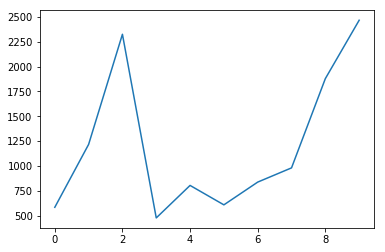

In [100]:
plt.plot(dist[:10])
plt.show()

In [116]:
change=np.where(dist>2000)[0]+1

In [119]:
change=np.where(dist>2000)[0]+1
change=np.concatenate([[0],change])

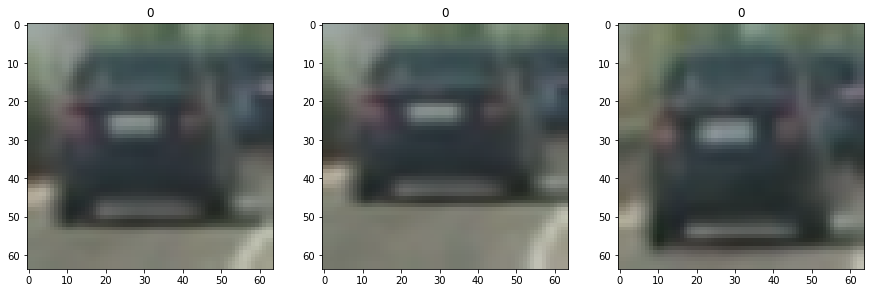

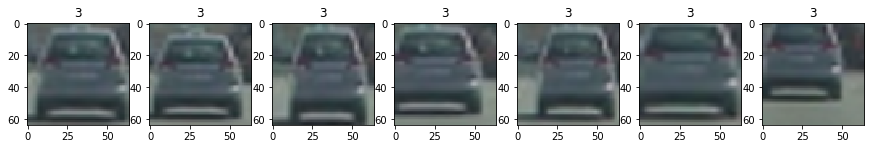

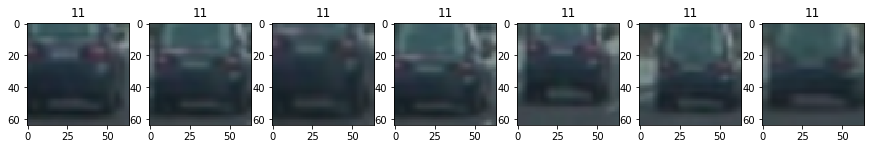

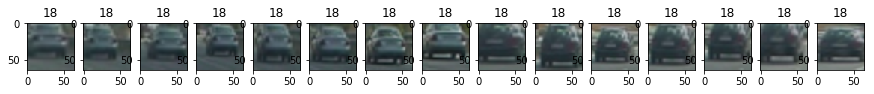

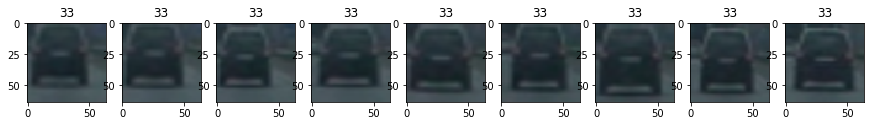

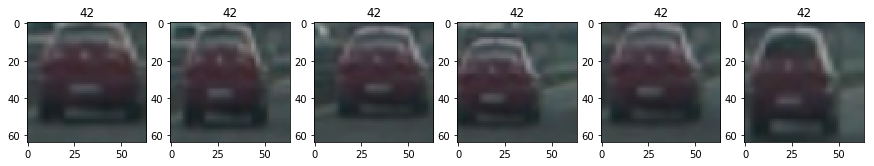

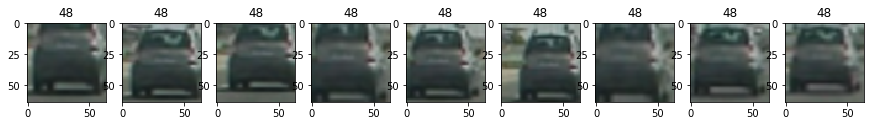

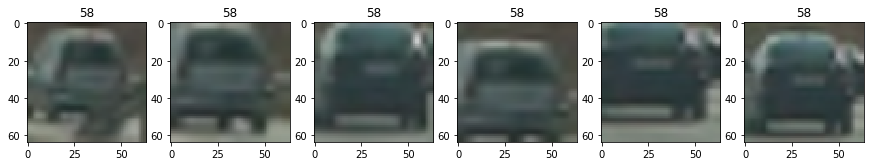

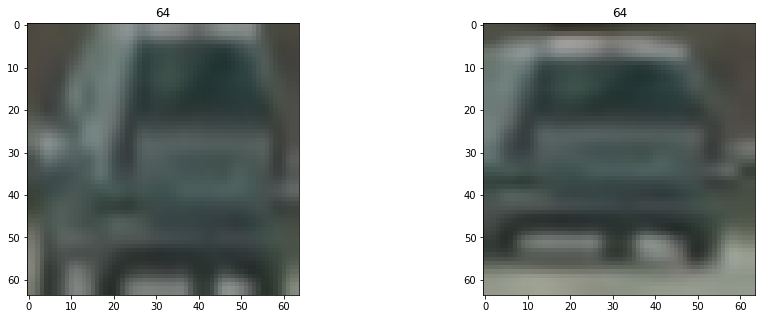

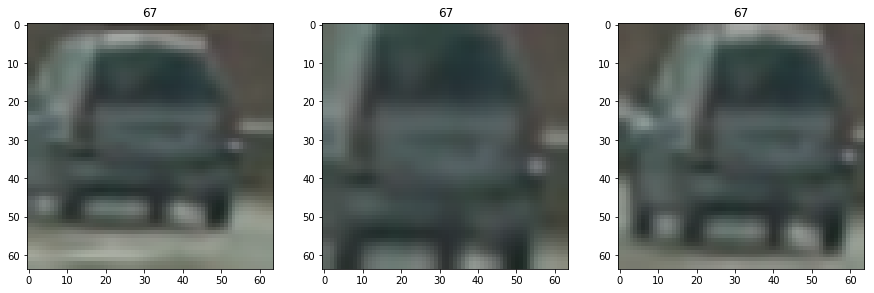

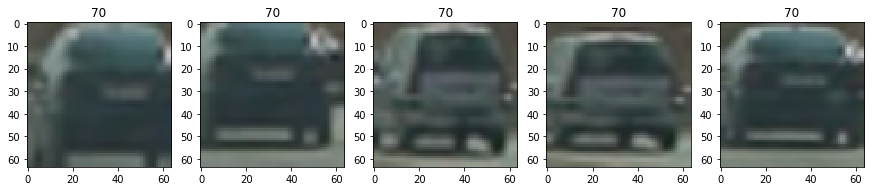

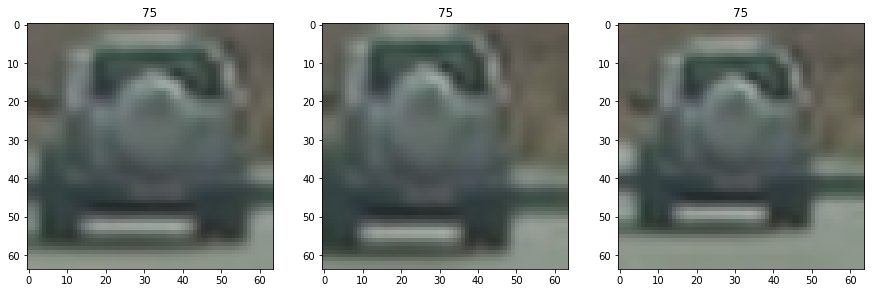

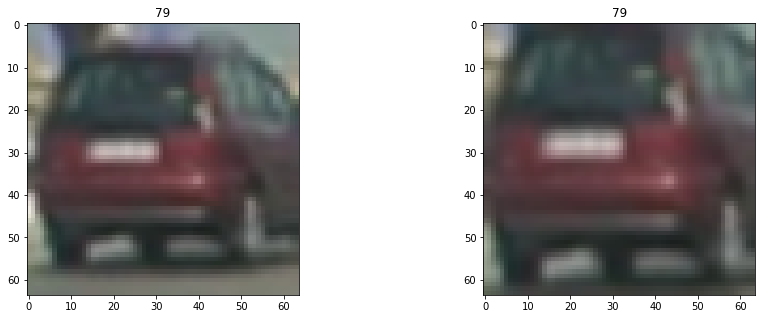

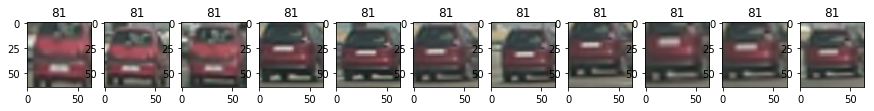

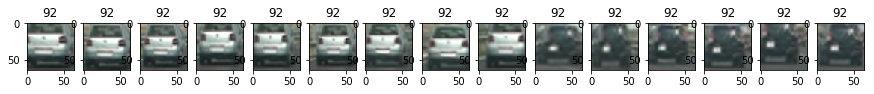

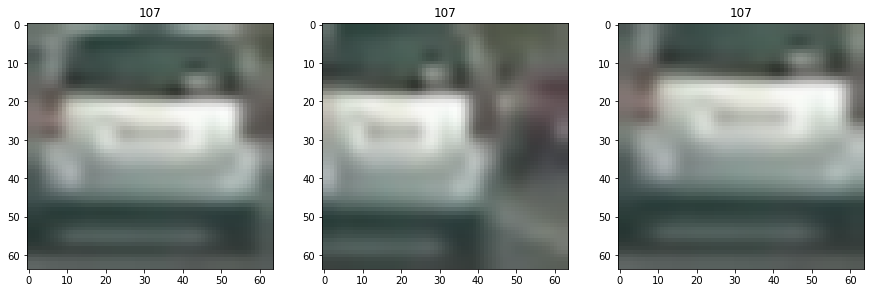

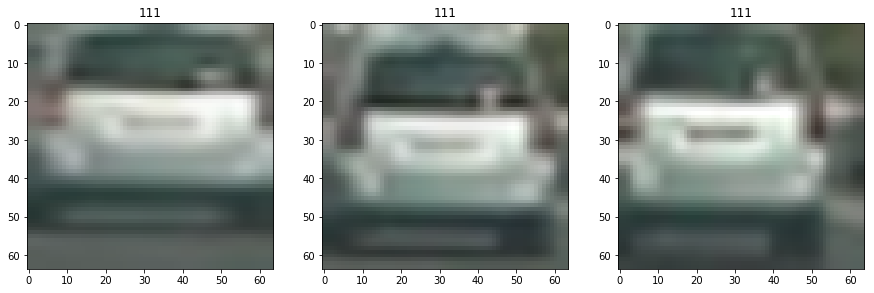

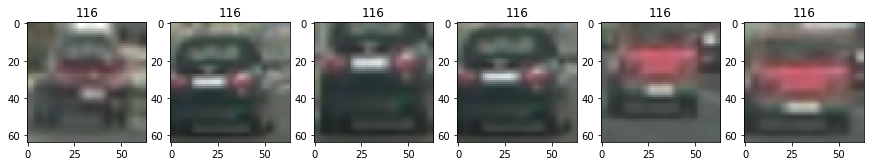

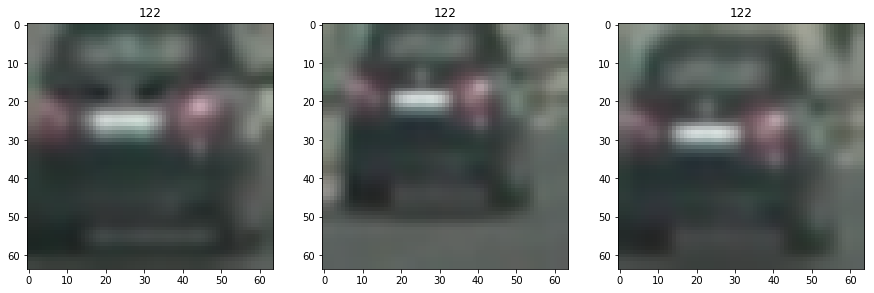

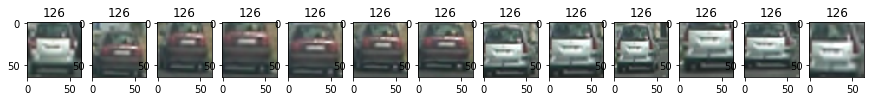

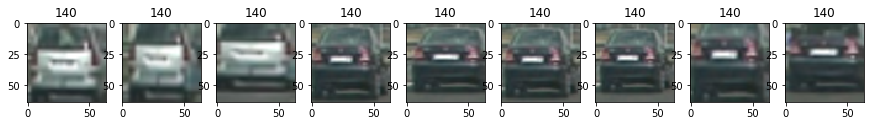

In [136]:
change=np.where(dist>2000)[0]+1
change=np.concatenate([[0],change])

las_features=np.zeros_like(ch[0])

q=0

for begining,end in zip(change[:-1],change[1:]):
    if end>begining+1:
        #plt.plot(change[begining:end])
        #plt.show()
        fig, ax = plt.subplots(1,end-begining)
        fig.set_figwidth(15)
        fig.set_figheight(5)
        for i in range(begining,end):
            img=mpl.image.imread(gl_far[i])
            ax[i-begining].imshow(img)
            ax[i-begining].set_title(str(begining))
        plt.show()
        q+=1
        if q>20:
            break

In [130]:
len(change)

94

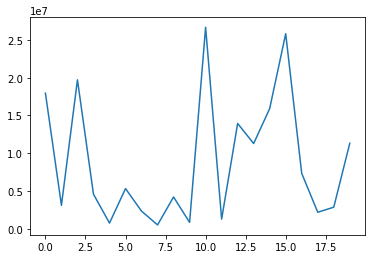

In [94]:
gl_nonv=glob.glob('data/non-vehicles/GTI/*')
ch2=get_hist_features(gl_nonv)
dist2=((ch2[:-1]-ch2[1:])**2).sum(axis=1)
plt.plot(dist2[:20])
plt.show()

In [35]:
cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

array([[[239, 106, 151],
        [241, 100, 142],
        [209,  93, 130],
        ..., 
        [ 33,  92, 125],
        [ 36,  92, 125],
        [ 49,  92, 125]],

       [[241, 100, 142],
        [198,  94, 133],
        [163,  88, 120],
        ..., 
        [113,  85, 111],
        [ 80,  87, 113],
        [ 32,  91, 119]],

       [[206,  93, 130],
        [162,  87, 121],
        [158,  82, 109],
        ..., 
        [148,  80,  98],
        [141,  80,  98],
        [101,  83, 100]],

       ..., 
       [[142, 101, 139],
        [132, 101, 139],
        [111, 103, 140],
        ..., 
        [ 91, 105, 143],
        [ 91, 105, 143],
        [106, 105, 143]],

       [[164, 101, 139],
        [133, 101, 139],
        [117, 103, 140],
        ..., 
        [100, 105, 143],
        [102, 105, 143],
        [104, 105, 143]],

       [[188, 101, 139],
        [136, 101, 139],
        [128, 101, 141],
        ..., 
        [ 89, 105, 143],
        [ 87, 105, 143],
        [ 63, 105,

In [39]:
extract_features([img], color_space='LUV', 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, from_file=False,preprocessing=False)[0]

/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


array([  1.55000000e+02,   7.80000000e+01,   9.20000000e+01, ...,
         1.79285447e-02,   1.28751559e-02,   1.16886692e-02])

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

l=Line()
clip1 = VideoFileClip(videofile)
white_clip = clip1.fl_image(l.process_img) #NOTE: this function expects color images!!
white_clip.write_videofile(videofile.replace('video','anotated'), audio=False)


